## Decomposition of moisture transport 

-  mean flow vs. eddies (timeseries and corr)
-  thermodynamic vs. dynamic (Tinghai data and correlation)
-  AWT Tinghai 
- surface tmpereature increase -> specific humidity 

In [2]:
import xarray as xr 
import matplotlib.pyplot as plt 
import numpy as np 
import quiver 
import matplotlib.colors as colors
import cartopy.crs as ccrs
import atmotrans as atm 
from atmotrans import R,c

In [3]:
## elevation for contour of TP 
import xarray
dem = '/media/juli/Data/projects/data/elevation/elevation_600x350.nc'
elevations = xarray.open_dataarray(dem)

In [4]:
# ERA5 climatology 

awt= 'tmpdir/monthly/awt_clim.nc'
awt = xr.open_dataset(awt, decode_times=False)
lons = awt.longitude.values
lats = awt.latitude.values
awt_u= awt['p71.162'][0]
awt_v= awt['p72.162'][0]
q_clim = np.abs(awt_u ) + np.abs(awt_v)

awt = 'tmpdir/monthly/awt_clim05_.nc'
awt_may = xr.open_dataset(awt)
awt_u_may= awt_may['p71.162'][0]
awt_v_may= awt_may['p72.162'][0]
q_may = np.abs(awt_u_may) + np.abs(awt_v_may)
               
awt = 'tmpdir/monthly/awt_clim06_.nc'
awt_jun = xr.open_dataset(awt)
awt_u_jun= awt_jun['p71.162'][0]
awt_v_jun= awt_jun['p72.162'][0]
q_jun = np.abs(awt_u_jun) + np.abs(awt_v_jun)

awt = 'tmpdir/monthly/awt_clim07_.nc'
awt_jul = xr.open_dataset(awt)
awt_u_jul= awt_jul['p71.162'][0]
awt_v_jul= awt_jul['p72.162'][0]
q_jul = np.abs(awt_u_jul) + np.abs(awt_v_jul)

awt = 'tmpdir/monthly/awt_clim08_.nc'
awt_aug = xr.open_dataset(awt)
awt_u_aug= awt_aug['p71.162'][0]
awt_v_aug= awt_aug['p72.162'][0]
q_aug = np.abs(awt_u_aug) + np.abs(awt_v_aug)

awt = 'tmpdir/monthly/awt_clim09_.nc'
awt_sep = xr.open_dataset(awt)
awt_u_sep= awt_sep['p71.162'][0]
awt_v_sep= awt_sep['p72.162'][0]
q_sep = np.abs(awt_u_sep) + np.abs(awt_v_sep)


# convert coords to 2d array 
lons,lats = np.meshgrid(lons, lats)


## Monthly climatology WRF downscaling 1979 - 1987 

In [550]:
def column_integration(values, z, ax = None ):
    if ax == None:
        ax = 0
    # integration of column values without z conversion 
    colint = np.trapz(values,z, axis =ax )
    return colint

In [13]:
dataset= '/media/juli/Data/projects/moisture_transport/moisture_transport/wrftp/data/monthly/wrfout_awt_19982006.nc'

data= xr.open_dataset(dataset)
q = data.r_v_p[0]
u = data.u_tr_p[0]
v = data.v_tr_p[0]
z = data.Z_p[0]
t = data.T_p[0].values

q=np.nan_to_num(q, 0)
z=np.nan_to_num(z, 0)
u_wrf=np.nan_to_num(u, 0)
v_wrf=np.nan_to_num(v, 0)
#t=np.nan_to_num(t, 0)

pressure = data.pressure.values
data.close()

# convert specific humidity to absolute humidity in kg/m3                                                                                          
for plev in np.arange(29):
    p_d = (pressure[plev] * 100)/(R*t[plev])
    q[plev] =q[plev]* p_d
    
q_wrf=np.nan_to_num(q, 0)
q_wrf = column_integration(q_wrf,z,ax=0 )

awt_u_wrf = column_integration(q_wrf*u_wrf,z, ax=0 )
awt_v_wrf = column_integration(q_wrf*v_wrf,z,ax=0 )
#q_wrf = np.abs(awt_u_wrf) + np.abs(awt_v_wrf)

NameError: name 'column_integration' is not defined

In [14]:
wrf_lon= data.lon.values
wrf_lat = data.lat.values 
dlat,dlon= atm.get_spacing(wrf_lat[:,0],wrf_lon[0])

# horizontal divergence
udev = atm.dy_dlon(awt_u_wrf, dlon) 
vdev = atm.dy_dlat(awt_v_wrf, dlat) 
udiv = np.hstack([udev,np.zeros((549,2))])
vdiv = np.vstack([vdev, np.zeros((2,729))])

NameError: name 'awt_u_wrf' is not defined

In [1021]:
def wrf_derivative_v(qvint):
    qvint_padded = qvint[:-1, :-1]
    f_qvint = np.fft.fft(qvint_padded, axis=0)

    m, n = f_qvint.shape
    m2 = m // 2
    n2 = n // 2

    f_lat = 2.0 * np.pi * np.fft.fftfreq(m, d= 9000 ) 
    f_lat[m2] = 0.0
    f_lat = np.broadcast_to(f_lat.reshape(-1, 1), (m, n))  
    
    df_qvint_dy = f_qvint.copy() * -1j * f_lat
    
    d_m = 729
    df_qvint_dy[m2 - d_m : m2 + d_m + 1, :] *= 0.0
    
    return np.fft.ifft(df_qvint_dy, axis = 0).real


In [1058]:
def wrf_derivative_u(quint):
    quint_padded = np.hstack([np.fliplr(quint[:-1, :-1]), quint[:-1, :-1], np.fliplr(quint[:-1, :-1])]) 
    f_quint = np.fft.fft(quint_padded, axis=1)

    m, n = f_quint.shape
    m2 = m // 2
    n2 = n // 2
    f_lon= f_quint.copy()
    
    f_lon = 2.0 * np.pi * np.fft.fftfreq(n, d= 9000)
    f_lon[n2] = 0.0
    
    f_lon = np.broadcast_to(f_lon.reshape(1, -1), (m, n)) 
    df_quint_dx = f_quint.copy() * 1j * f_lon 
    
    d_n = 700
    df_quint_dx[:, n2 - d_n : n2 + d_n + 1] *= 0.0
    
    d_n = 500
    df_quint_dx[:, n2 - d_n : n2 + d_n + 1] *= 0.0

    d_n = 300
    df_quint_dx[:, n2 - d_n : n2 + d_n + 1] *= 0.0


    
    return np.fft.ifft(df_quint_dx, axis = 1).real

In [1059]:
udiv = wrf_derivative_u(awt_u_wrf)[:,729:728*2]

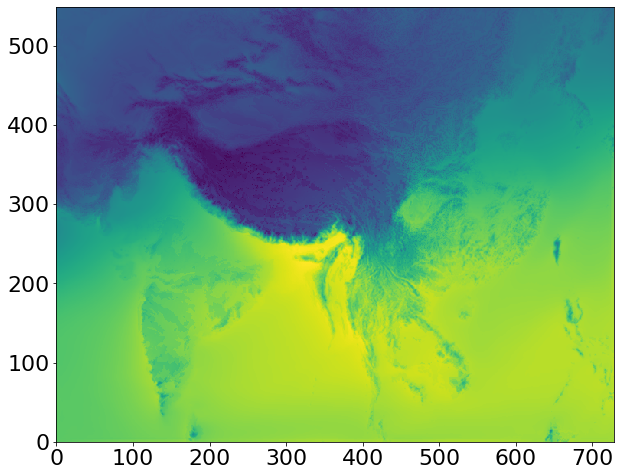

In [1063]:
plt.figure(figsize=(10,8))
plt.pcolormesh(q_int_wrf)

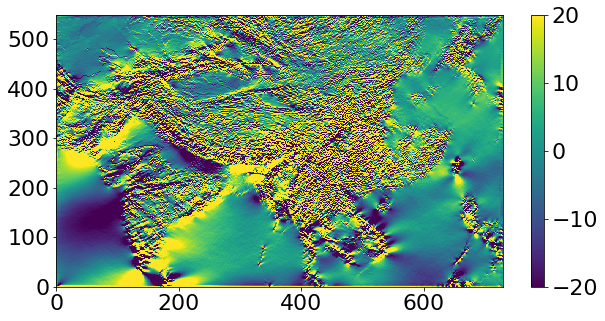

In [1068]:
plt.figure(figsize=(10,5))
plt.pcolormesh(vdiv*86400,vmin =-20,vmax=20)
plt.colorbar()

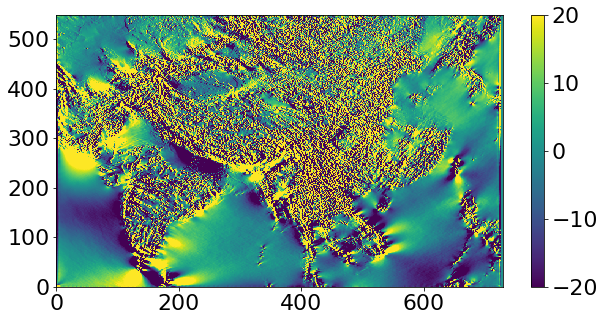

In [1069]:
plt.figure(figsize=(10,5))
plt.pcolormesh(udiv*86400,vmin =-20,vmax=20)
plt.colorbar()
plt.savefig('high_freq_derivative_wrf.png')

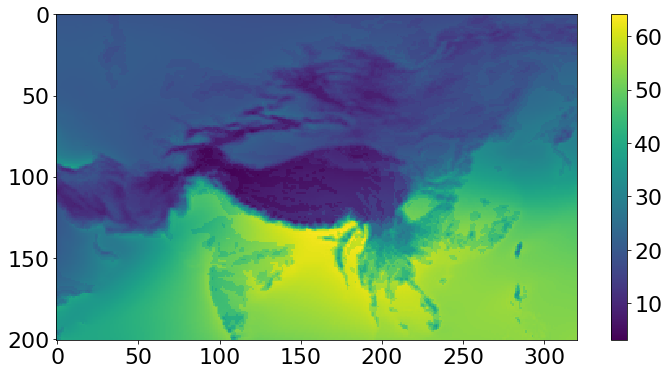

In [872]:
plt.figure(figsize=(12,6))
plt.imshow(tcwv)
plt.colorbar()

In [1074]:
dataset= '/media/juli/Data/projects/moisture_transport/moisture_transport/wrftp/data/monthly/wrfout_awt_19791987.nc'
cld_dataset= '/media/juli/Data/projects/moisture_transport/moisture_transport/wrftp/data/monthly/wrfout_awt_19791987_cld.nc'

data= xr.open_dataset(dataset)
cld_data= xr.open_dataset(cld_dataset)

cloud_particles = cld_data.r_solid_p[0] + cld_data.r_rain_p[0]
q = data.r_v_p[0] 
u = data.u_tr_p[0]
v = data.v_tr_p[0]
z = data.Z_p[0]
t = data.T_p[0].values

q=np.nan_to_num(q, 0)
cloud_particles=np.nan_to_num(cloud_particles, 0)
z=np.nan_to_num(z, 0)
u_wrf_ago=np.nan_to_num(u, 0)
v_wrf_ago=np.nan_to_num(v, 0)
#t=np.nan_to_num(t, 0)

pressure_wrf = data.pressure.values
data.close()

# convert specific humidity to absolute humidity in kg/m3                                                                                          
for plev in np.arange(29):
    p_d = (pressure[plev] * 100)/(R*t[plev])
    q[plev] =q[plev]* p_d
    cloud_particles[plev] = cloud_particles[plev]* p_d
      
q_wrf_ago=np.nan_to_num(q, 0)

cloud_particles=np.nan_to_num(cloud_particles, 0)

awt_u_wrf_ago = column_integration(q*u,z, ax=0 )
awt_v_wrf_ago = column_integration(q*v,z,ax=0 )
q_wrf_ago = column_integration(q_wrf_ago ,z,ax=0 )


cloud_particles = column_integration(cloud_particles,z,ax=0 )
#q_wrf_ago = np.abs(awt_u_wrf_ago) + np.abs(awt_v_wrf_ago)

# difference in AWT
awt_u_wrf_diff = awt_u_wrf - awt_u_wrf_ago
awt_v_wrf_diff = awt_v_wrf - awt_v_wrf_ago
q_wrf_diff = np.abs(awt_u_wrf_diff) + np.abs(awt_v_wrf_diff)

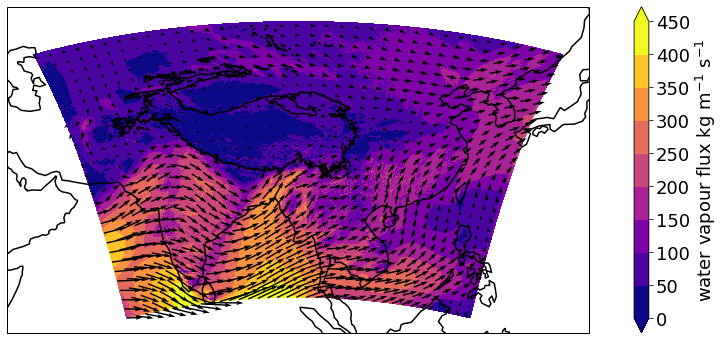

In [64]:
# plot

plot_awt(awt_u_wrf,awt_v_wrf, q_wrf,data.lon.values, data.lat.values)


## ERA5 vs. WRF 1979 - 1987 

In [466]:
awt= 'tmpdir/monthly/awt_19791987_clim.nc'
awt = xr.open_dataset(awt, decode_times=False)
awt_u_ago= awt['p71.162'][0]
awt_v_ago= awt['p72.162'][0]
q_clim_ago = np.abs(awt_u_ago ) + np.abs(awt_v_ago)

awt= 'tmpdir/monthly/awt_19982006_clim.nc'
awt = xr.open_dataset(awt, decode_times=False)
awt_u= awt['p71.162'][0]
awt_v= awt['p72.162'][0]
q_clim = np.abs(awt_u ) + np.abs(awt_v)

# difference in AWT
awt_u_diff = awt_u - awt_u_ago
awt_v_diff = awt_v - awt_v_ago

q_clim_diff = np.abs(awt_u_diff ) + np.abs(awt_v_diff)

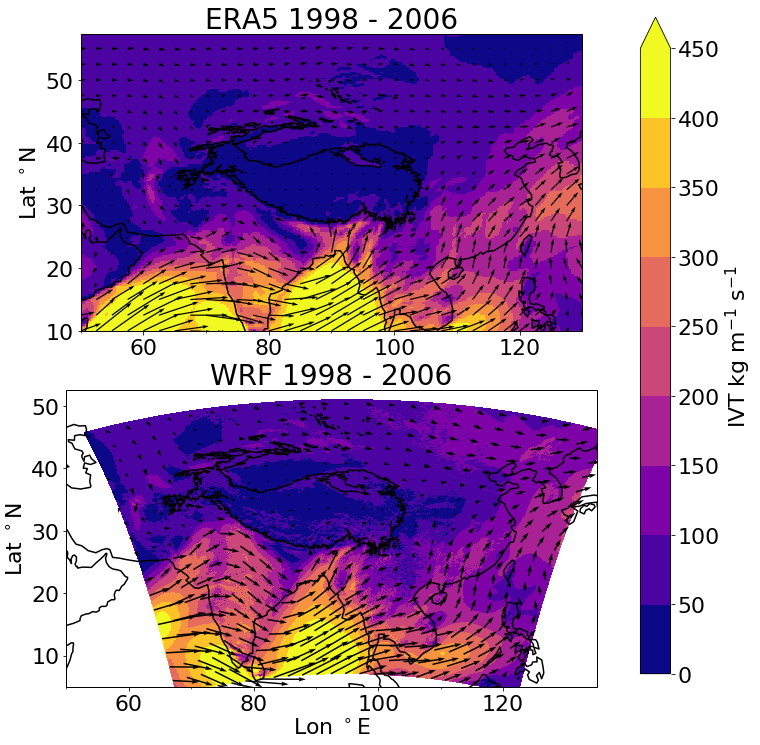

In [209]:
fig =plt.figure(figsize=(12,12))

xlabels=[50,60,70,80,90,100,110,120]
ylabels= [10,20,30,40,50]
skip  =(slice(None,None,10),slice(None,None,10))
fs= 22
c= 'k'


# customizing of colorbar 
cmap=plt.cm.plasma
r = np.arange(0,500,50)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)


## ERA5 
ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax1.set_extent([50,130,10,50])
ax1.set_title('ERA5 1998 - 2006', fontsize= 28 )
ax1.coastlines(linewidth = 1.5)
ax1.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# Plot wind vectors 

x,y = lons,lats
skip  =(slice(None,None,10),slice(None,None,10))
ax1.pcolormesh(lons, lats, q_clim,norm = norm, cmap = cmap  )    
ax1.quiver(x[skip],y[skip],awt_u[skip], awt_v[skip], color =c, transform= ccrs.PlateCarree()) 
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=fs)
      
    
## WRF
ax2 = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree())
ax2.set_title('WRF 1998 - 2006', fontsize= 28)
ax2.set_extent([55,135,5,45])
m = ax2.pcolormesh(data.lon.values, data.lat.values, q_wrf , transform= ccrs.PlateCarree(), cmap = 'plasma', norm = norm)
ax2.coastlines(linewidth = 1.5)
ax2.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# convert coords to 2d array 
x,y = data.lon.values, data.lat.values
# Plot wind vectors 
skip  =(slice(None,None,30),slice(None,None,30))
ax2.quiver(x[skip],y[skip],awt_u_wrf[skip], awt_v_wrf[skip], color ='k', transform= ccrs.PlateCarree())
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)
ax2.set_xlabel('Lon $^\circ$E',  fontsize=fs)
ax2.set_ylabel('Lat $^\circ$N',  fontsize=fs)

cb_ax1 = fig.add_axes([0.87, 0.14,0.035, 0.76])
#cb_ax1 = fig.add_axes([0.03, 0.04, 0.835, 0.056])
cbar = fig.colorbar(m, cax=cb_ax1, extend = 'max', label = 'IVT kg m$^{-1}$ s$^{-1}$')
plt.rcParams.update({'font.size': 22})



plt.savefig('plots/AWT_climatology_1998-2006.png')
plt.show()

## Humidity vs. wind changes ERA5 and WRF 9 km

In [641]:
era_data = xr.open_dataset('cache/era5_fields_19791987.nc')
era= xr.open_dataset('cache/era5_fields_19982006.nc')
era_temp = xr.open_dataset('cache/era5_temp_19791987.nc')
era_pressure = xr.open_dataset('cache/srfc-monthly/srfc_pressure_19791987.nc')
era_t= era_temp.t[0]
era_sp= era_pressure.sp[0].values/ 100

era_q = era_data.q[0]
era_u_ago = era_data.u[0]
era_v_ago = era_data.v[0]
era_z = era_data.z[0]
pressure= era_data.level.values 

era_u = era.u[0]
era_v = era.v[0]

# convert specific humidity to absolute humidity in kg/m3
for plev in np.arange(37):
    p_d = (pressure[plev] * 100)/(R*era_t[plev])
    era_q[plev] = era_q[plev]* p_d    

In [585]:
# set z to 0 where surface pressure< 1000 hpa 
coords = np.where(era_sp < 1000)
for i, ilat in enumerate(coords[0]):
    ilon = coords[1][i]
    sp_value = era_sp[ilat,ilon]
    idx, pl = atm.find_nearest_idx(pressure, sp_value)
    if sp_value > pl:
        idx = idx + 1   
    # set q value below ground to 0 
    era_q[idx:36, ilat, ilon] =  0

In [586]:
tcwv_ago = atm.column_integration(np.flip(era_q, axis = 0 ), np.flip(era_z, axis = 0 ))

In [582]:
tcwv = atm.column_integration(np.flip(era_q, axis = 0 ), np.flip(era_z, axis = 0 ))

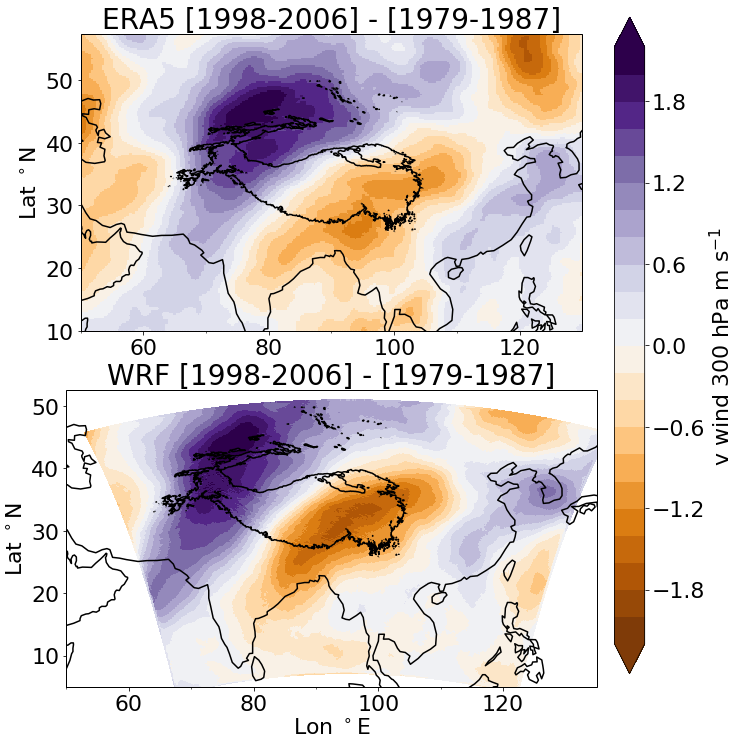

In [667]:
fig =plt.figure(figsize=(12,12))

xlabels=[50,60,70,80,90,100,110,120]
ylabels= [10,20,30,40,50]
skip  =(slice(None,None,10),slice(None,None,10))
fs= 22
c= 'k'

# customizing of colorbar 
cmap=plt.cm.PuOr
r = np.arange(-2.2,2.4,0.2)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)

## ERA5 
ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax1.set_extent([50,130,10,50])
ax1.set_title('ERA5 [1998-2006] - [1979-1987]', fontsize= 28 )
ax1.coastlines(linewidth = 1.5)
ax1.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.pcolormesh(lons, lats, era_v[17] - era_v_ago[17],norm = norm, cmap = cmap  )    
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=fs)
      
## WRF
ax2 = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree())
ax2.set_title('WRF [1998-2006] - [1979-1987]', fontsize= 28)
ax2.set_extent([55,135,5,45])
m = ax2.pcolormesh(data.lon.values, data.lat.values, v_wrf[-10]-v_wrf_ago[-10] , transform= ccrs.PlateCarree(), cmap = cmap, norm = norm)
ax2.coastlines(linewidth = 1.5)
ax2.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)
ax2.set_xlabel('Lon $^\circ$E',  fontsize=fs)
ax2.set_ylabel('Lat $^\circ$N',  fontsize=fs)

cb_ax1 = fig.add_axes([0.84, 0.14,0.035, 0.76])
#cb_ax1 = fig.add_axes([0.03, 0.04, 0.835, 0.056])
cbar = fig.colorbar(m, cax=cb_ax1, extend = 'both', label = 'v wind 300 hPa m s$^{-1}$')
plt.rcParams.update({'font.size': 22})



plt.savefig('plots/ERA5_vs_WRF9km_vwind300.png')
plt.show()

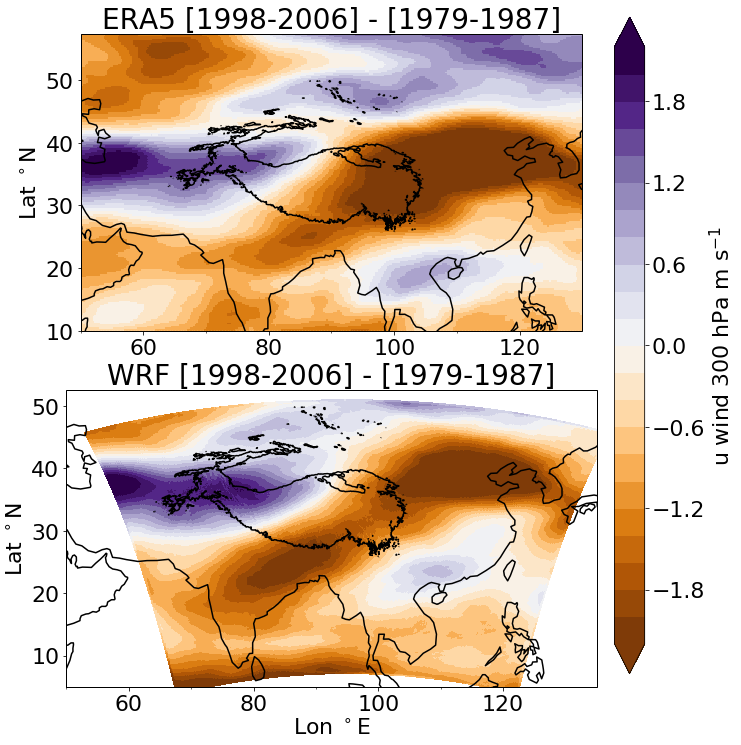

In [665]:
fig =plt.figure(figsize=(12,12))

xlabels=[50,60,70,80,90,100,110,120]
ylabels= [10,20,30,40,50]
skip  =(slice(None,None,10),slice(None,None,10))
fs= 22
c= 'k'

# customizing of colorbar 
cmap=plt.cm.PuOr
r = np.arange(-2.2,2.4,0.2)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)

## ERA5 
ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax1.set_extent([50,130,10,50])
ax1.set_title('ERA5 [1998-2006] - [1979-1987]', fontsize= 28 )
ax1.coastlines(linewidth = 1.5)
ax1.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.pcolormesh(lons, lats, era_u[17] - era_u_ago[17],norm = norm, cmap = cmap  )    
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=fs)
      
## WRF
ax2 = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree())
ax2.set_title('WRF [1998-2006] - [1979-1987]', fontsize= 28)
ax2.set_extent([55,135,5,45])
m = ax2.pcolormesh(data.lon.values, data.lat.values, u_wrf[-10]-u_wrf_ago[-10] , transform= ccrs.PlateCarree(), cmap = cmap, norm = norm)
ax2.coastlines(linewidth = 1.5)
ax2.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)
ax2.set_xlabel('Lon $^\circ$E',  fontsize=fs)
ax2.set_ylabel('Lat $^\circ$N',  fontsize=fs)

cb_ax1 = fig.add_axes([0.84, 0.14,0.035, 0.76])
#cb_ax1 = fig.add_axes([0.03, 0.04, 0.835, 0.056])
cbar = fig.colorbar(m, cax=cb_ax1, extend = 'both', label = 'u wind 300 hPa m s$^{-1}$')
plt.rcParams.update({'font.size': 22})

plt.savefig('plots/ERA5_vs_WRF9km_uwind300.png')
plt.show()

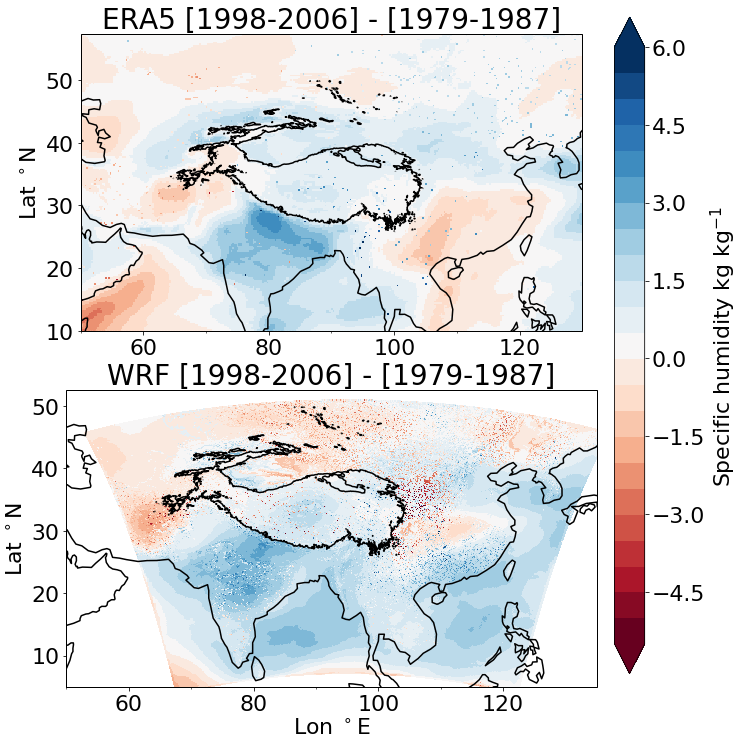

In [1096]:
fig =plt.figure(figsize=(12,12))

xlabels=[50,60,70,80,90,100,110,120]
ylabels= [10,20,30,40,50]
skip  =(slice(None,None,10),slice(None,None,10))
fs= 22
c= 'k'

# customizing of colorbar 
cmap=plt.cm.RdBu
#cmap = plt.cm.PuBu
r = np.arange(-5.5,6.5,0.5)
#r = np.arange(0,65,5)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)

## ERA5 
ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax1.set_extent([50,130,10,50])
ax1.set_title('ERA5 [1998-2006] - [1979-1987]', fontsize= 28 )
ax1.coastlines(linewidth = 1.5)
ax1.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.pcolormesh(lons, lats, tcwv -tcwv_ago,norm = norm, cmap = cmap  )   
#ax1.pcolormesh(data.lon.values, data.lat.values, q_wrf, transform= ccrs.PlateCarree(), cmap = cmap, norm = norm)
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=fs)
      
## WRF
ax2 = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree())
ax2.set_title('WRF [1998-2006] - [1979-1987]', fontsize= 28)
ax2.set_extent([55,135,5,45])
m = ax2.pcolormesh(data.lon.values, data.lat.values, q_wrf - q_wrf_ago, transform= ccrs.PlateCarree(), cmap = cmap, norm = norm)
ax2.coastlines(linewidth = 1.5)
ax2.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)
ax2.set_xlabel('Lon $^\circ$E',  fontsize=fs)
ax2.set_ylabel('Lat $^\circ$N',  fontsize=fs)

cb_ax1 = fig.add_axes([0.84, 0.14,0.035, 0.76])
#cb_ax1 = fig.add_axes([0.03, 0.04, 0.835, 0.056])
cbar = fig.colorbar(m, cax=cb_ax1, extend = 'both', label = 'Specific humidity kg kg$^{-1}$')
plt.rcParams.update({'font.size': 22})

plt.savefig('plots/ERA5_vs_WRF9km_humidity_changes.png')
plt.show()

## Monthly climatology ERA5 

In [15]:
def quick_plot(data):
    plt.figure(figsize=(15,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    m = plt.pcolormesh(lons,lats, data, transform= ccrs.PlateCarree())
    plt.colorbar()

In [1124]:
def plot_awt(awt_u, awt_v, q, lons,lats):
    
    # customizing of colorbar 
    cmap=plt.cm.plasma
    r = np.arange(0,500,50)
    norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
    
    plt.figure(figsize=(20,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    m = plt.pcolormesh(lons, lats, q, transform= ccrs.PlateCarree(), cmap = 'plasma', norm = norm)
    ax.set_extent([60,130,10,50])
    ax.coastlines(linewidth = 1.5)
    plt.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')

    # Normalise the data for uniform arrow size
    #u_norm = awt_u/ np.sqrt(awt_u ** 2.0 + awt_u ** 2.0)
    #v_norm = awt_v / np.sqrt(awt_v ** 2.0 + awt_v ** 2.0)
    
    # convert coords to 2d array 
    x,y = lons, lats
    
    # tick labels 
    xlabels=[50,60,70,80,90,100,110,120]
    ylabels= [10,20,30,40,50]
    ax.set_xticks(xlabels, xlabels)
    ax.set_yticks(ylabels,ylabels)
    ax.set_xlabel('Lon $^\circ$E',  fontsize=fs)
    ax.set_ylabel('Lat $^\circ$N',  fontsize=fs)

    # Plot wind vectors 
    skip  =(slice(None,None,10),slice(None,None,10))
    ax.quiver(x[skip],y[skip],awt_u[skip], awt_v[skip], color ='k', transform= ccrs.PlateCarree())

    cbar = plt.colorbar(m,extend= 'max',  label = 'IVT kg m$^{-1}$ s$^{-1}$')
    plt.rcParams.update({'font.size': 22})
    
    plt.savefig('plots/mean_awt.png')

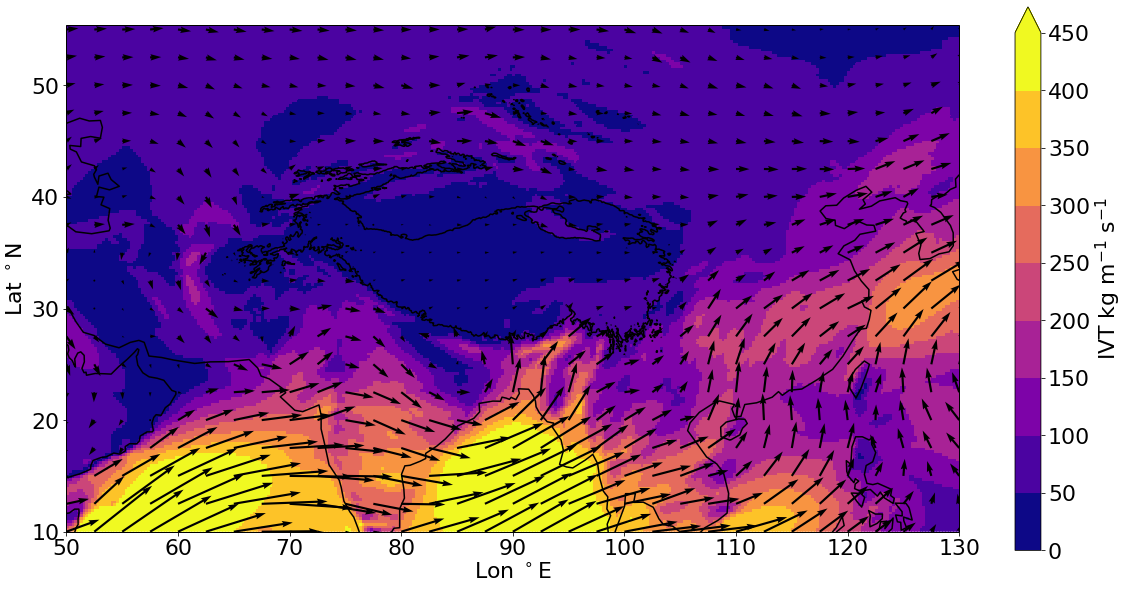

In [1126]:
plot_awt(awt_u, awt_v, q_clim,lons,lats)

## Climatology of water vapor transport (evolution of monsoon ) ERA5 

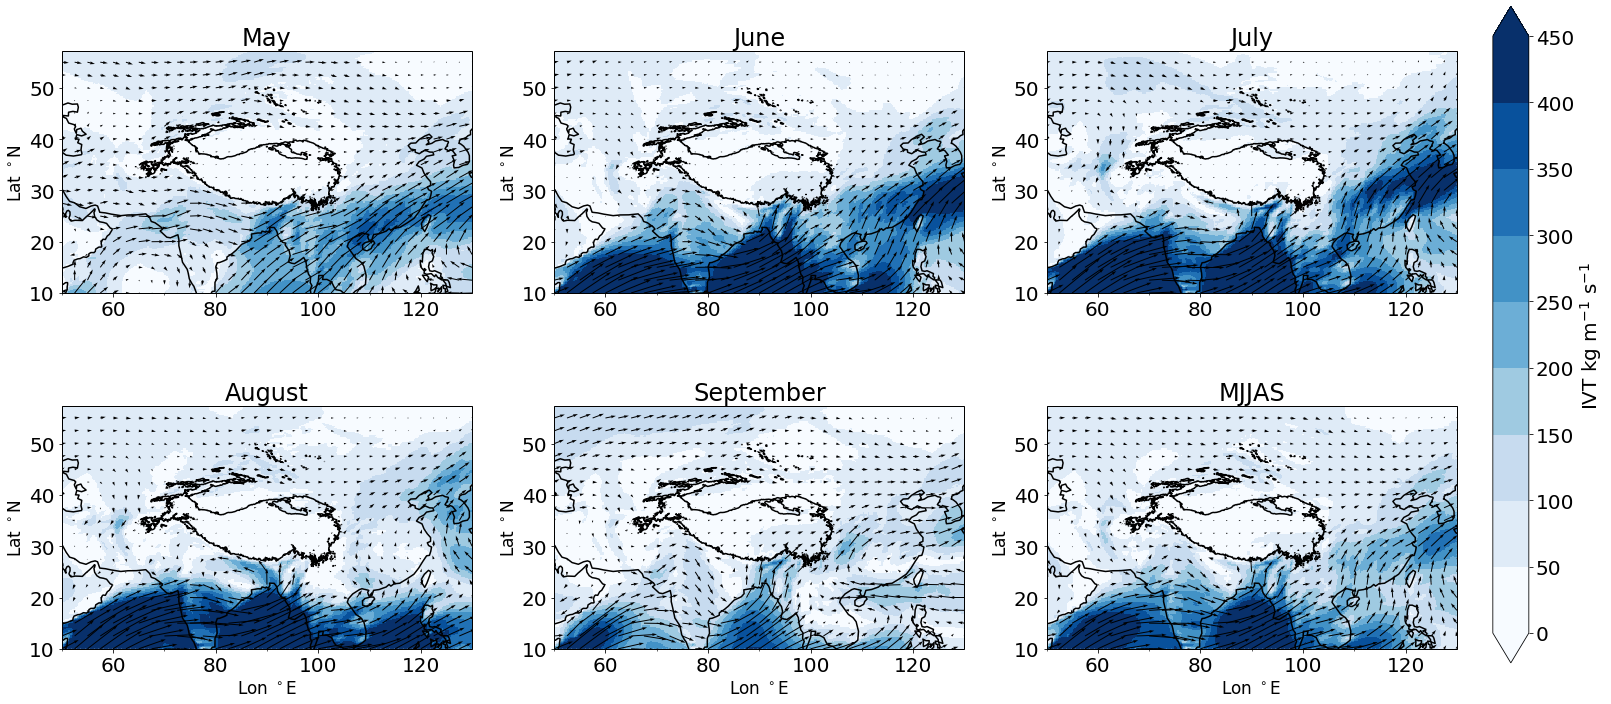

In [6]:
fig =plt.figure(figsize=(25,12))
xlabels=[50,60,70,80,90,100,110,120]
ylabels= [10,20,30,40,50]
skip  =(slice(None,None,10),slice(None,None,10))
fs= 17
c= 'k'

# customizing of colorbar 
cmap=plt.cm.Blues
r = np.arange(0,500,50)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)

skip  =(slice(None,None,10),slice(None,None,10))
x,y = lons, lats

ax1 = plt.subplot(2, 3, 1, projection=ccrs.PlateCarree())
ax1.set_extent([50,130,10,50])
ax1.set_title('May')
ax1.coastlines(linewidth = 1.5)
ax1.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# Plot wind vectors 
ax1.pcolormesh(lons, lats, q_may,norm = norm, cmap = cmap  )    
ax1.quiver(x[skip],y[skip],awt_u_may[skip], awt_v_may[skip], color =c, transform= ccrs.PlateCarree()) 
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=fs)
    

ax2 = plt.subplot(2, 3, 2, projection=ccrs.PlateCarree())
ax2.set_extent([50,130,10,50])
ax2.set_title('June')
ax2.coastlines(linewidth = 1.5)
ax2.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# Plot wind vectors 
ax2.pcolormesh(lons, lats, q_jun,norm = norm, cmap = cmap  )
ax2.quiver(x[skip],y[skip],awt_u_jun[skip], awt_v_jun[skip], color =c, transform= ccrs.PlateCarree())
# axis labels 
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)
ax2.set_ylabel('Lat $^\circ$N',  fontsize=fs)
     

ax3 = plt.subplot(2, 3, 3, projection=ccrs.PlateCarree())
ax3.set_extent([50,130,10,50])
ax3.set_title('July')
ax3.coastlines(linewidth = 1.5)
ax3.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# Plot wind vectors 
ax3.pcolormesh(lons, lats, q_jul,norm = norm, cmap = cmap  )
ax3.quiver(x[skip],y[skip],awt_u_jul[skip], awt_v_jul[skip], color =c, transform= ccrs.PlateCarree())
# axis labels 
ax3.set_xticks(xlabels, xlabels)
ax3.set_yticks(ylabels,ylabels)
ax3.set_ylabel('Lat $^\circ$N',  fontsize=fs)
   

ax4 = plt.subplot(2, 3, 4, projection=ccrs.PlateCarree())
ax4.set_extent([50,130,10,50])
ax4.set_title('August')
ax4.pcolormesh(lons, lats, q_aug,norm = norm, cmap = cmap  )
ax4.coastlines(linewidth = 1.5)
ax4.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# Plot wind vectors 
ax4.quiver(x[skip],y[skip],awt_u_aug[skip], awt_v_aug[skip], color =c, transform= ccrs.PlateCarree())
# axis labels 
ax4.set_xticks(xlabels, xlabels)
ax4.set_yticks(ylabels,ylabels)
ax4.set_xlabel('Lon $^\circ$E',  fontsize=fs)
ax4.set_ylabel('Lat $^\circ$N',  fontsize=fs)
   
    
ax5 = plt.subplot(2, 3, 5, projection=ccrs.PlateCarree())
ax5.set_extent([50,130,10,50])
ax5.set_title('September')
ax5.coastlines(linewidth = 1.5)
ax5.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# Plot wind vectors 
ax5.pcolormesh(lons, lats, q_sep,norm = norm, cmap = cmap)
ax5.quiver(x[skip],y[skip],awt_u_sep[skip], awt_v_sep[skip], color =c, transform= ccrs.PlateCarree())
# axis labels 
ax5.set_xticks(xlabels, xlabels)
ax5.set_yticks(ylabels,ylabels)
ax5.set_xlabel('Lon $^\circ$E',  fontsize=fs)
ax5.set_ylabel('Lat $^\circ$N',  fontsize=fs)


ax6 = plt.subplot(2, 3, 6, projection=ccrs.PlateCarree())
ax6.set_extent([50,130,10,50])
ax6.set_title('MJJAS')
ax6.coastlines(linewidth = 1.5)
ax6.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# Plot wind vectors 
m = ax6.pcolormesh(lons, lats, q_clim ,norm = norm, cmap = cmap)
ax6.quiver(x[skip],y[skip],awt_u[skip], awt_v[skip], color =c, transform= ccrs.PlateCarree())
# axis labels 
ax6.set_xticks(xlabels, xlabels)
ax6.set_yticks(ylabels,ylabels)
ax6.set_xlabel('Lon $^\circ$E',  fontsize=fs)
ax6.set_ylabel('Lat $^\circ$N',  fontsize=fs)
      
    
cb_ax1 = fig.add_axes([0.92, 0.14,0.02, 0.76])
cbar = fig.colorbar(m, cax=cb_ax1, extend = 'both', label = 'IVT kg m$^{-1}$ s$^{-1}$')
plt.rcParams.update({'font.size': 20})


plt.savefig('plots/AWT_Climatology_ERA5.png')
plt.show()

## Climatology WRF (evolution of monsoon ) 

In [211]:

awt= 'wrftp/data/monthly/awt_clim.nc'
data = xr.open_dataset(awt)
q = data.r_v_p[0]
u = data.u_tr_p[0]
v = data.v_tr_p[0]
z = data.Z_p[0]
t = data.T_p[0].values
q=np.nan_to_num(q, 0)
z=np.nan_to_num(z, 0)
u=np.nan_to_num(u, 0)
v=np.nan_to_num(v, 0)
t=np.nan_to_num(t, 0)
pressure = data.pressure.values
lons = data.lon.values
lats = data.lat.values
data.close()

# convert specific humidity to absolute humidity in kg/m3                                                                                          
for plev in np.arange(29):
    p_d = (pressure[plev] * 100)/(R*t[plev])
    q[plev] =q[plev]* p_d
    
q=np.nan_to_num(q, 0)

awt_u= column_integration(q*u,z, ax=0 )
awt_v = column_integration(q*v,z,ax=0 )
q_clim = np.abs(awt_u) + np.abs(awt_v)



awt= 'wrftp/data/monthly/awt_clim05.nc'
data = xr.open_dataset(awt)
q = data.r_v_p[0]
u = data.u_tr_p[0]
v = data.v_tr_p[0]
z = data.Z_p[0]
t = data.T_p[0].values
q=np.nan_to_num(q, 0)
z=np.nan_to_num(z, 0)
u=np.nan_to_num(u, 0)
v=np.nan_to_num(v, 0)
t=np.nan_to_num(t, 0)
pressure = data.pressure.values
lons = data.lon.values
lats = data.lat.values
data.close()

# convert specific humidity to absolute humidity in kg/m3                                                                                          
for plev in np.arange(29):
    p_d = (pressure[plev] * 100)/(R*t[plev])
    q[plev] =q[plev]* p_d
    
q=np.nan_to_num(q, 0)

awt_u_may= column_integration(q*u,z, ax=0 )
awt_v_may = column_integration(q*v,z,ax=0 )
q_may = np.abs(awt_u_may) + np.abs(awt_v_may)

awt= 'wrftp/data/monthly/awt_clim06.nc'
data = xr.open_dataset(awt)
q = data.r_v_p[0]
u = data.u_tr_p[0]
v = data.v_tr_p[0]
z = data.Z_p[0]
t = data.T_p[0].values
q=np.nan_to_num(q, 0)
z=np.nan_to_num(z, 0)
u=np.nan_to_num(u, 0)
v=np.nan_to_num(v, 0)
t=np.nan_to_num(t, 0)
pressure = data.pressure.values
lons = data.lon.values
lats = data.lat.values
data.close()

# convert specific humidity to absolute humidity in kg/m3                                                                                          
for plev in np.arange(29):
    p_d = (pressure[plev] * 100)/(R*t[plev])
    q[plev] =q[plev]* p_d
    
q=np.nan_to_num(q, 0)

awt_u_jun= column_integration(q*u,z, ax=0 )
awt_v_jun = column_integration(q*v,z,ax=0 )
q_jun = np.abs(awt_u_jun) + np.abs(awt_v_jun)

awt= 'wrftp/data/monthly/awt_clim07.nc'
data = xr.open_dataset(awt)
q = data.r_v_p[0]
u = data.u_tr_p[0]
v = data.v_tr_p[0]
z = data.Z_p[0]
t = data.T_p[0].values
q=np.nan_to_num(q, 0)
z=np.nan_to_num(z, 0)
u=np.nan_to_num(u, 0)
v=np.nan_to_num(v, 0)
t=np.nan_to_num(t, 0)
pressure = data.pressure.values
lons = data.lon.values
lats = data.lat.values
data.close()

# convert specific humidity to absolute humidity in kg/m3                                                                                          
for plev in np.arange(29):
    p_d = (pressure[plev] * 100)/(R*t[plev])
    q[plev] =q[plev]* p_d
    
q=np.nan_to_num(q, 0)

awt_u_jul= column_integration(q*u,z, ax=0 )
awt_v_jul = column_integration(q*v,z,ax=0 )
q_jul = np.abs(awt_u_jul) + np.abs(awt_v_jul)

awt= 'wrftp/data/monthly/awt_clim08.nc'
data = xr.open_dataset(awt)
q = data.r_v_p[0]
u = data.u_tr_p[0]
v = data.v_tr_p[0]
z = data.Z_p[0]
t = data.T_p[0].values
q=np.nan_to_num(q, 0)
z=np.nan_to_num(z, 0)
u=np.nan_to_num(u, 0)
v=np.nan_to_num(v, 0)
t=np.nan_to_num(t, 0)
pressure = data.pressure.values
lons = data.lon.values
lats = data.lat.values
data.close()

# convert specific humidity to absolute humidity in kg/m3                                                                                          
for plev in np.arange(29):
    p_d = (pressure[plev] * 100)/(R*t[plev])
    q[plev] =q[plev]* p_d
    
q=np.nan_to_num(q, 0)

awt_u_aug= column_integration(q*u,z, ax=0 )
awt_v_aug = column_integration(q*v,z,ax=0 )
q_aug = np.abs(awt_u_aug) + np.abs(awt_v_aug)

awt= 'wrftp/data/monthly/awt_clim09.nc'
data = xr.open_dataset(awt)
q = data.r_v_p[0]
u = data.u_tr_p[0]
v = data.v_tr_p[0]
z = data.Z_p[0]
t = data.T_p[0].values
q=np.nan_to_num(q, 0)
z=np.nan_to_num(z, 0)
u=np.nan_to_num(u, 0)
v=np.nan_to_num(v, 0)
t=np.nan_to_num(t, 0)
pressure = data.pressure.values
lons = data.lon.values
lats = data.lat.values
data.close()

# convert specific humidity to absolute humidity in kg/m3                                                                                          
for plev in np.arange(29):
    p_d = (pressure[plev] * 100)/(R*t[plev])
    q[plev] =q[plev]* p_d
    
q=np.nan_to_num(q, 0)

awt_u_sep = column_integration(q*u,z, ax=0 )
awt_v_sep = column_integration(q*v,z,ax=0 )
q_sep = np.abs(awt_u_sep ) + np.abs(awt_v_sep )





/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in multiply
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in multiply
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in true_divide
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in multiply
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:107: RuntimeWarning: divide by zero encountered in true_divide
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: Runt

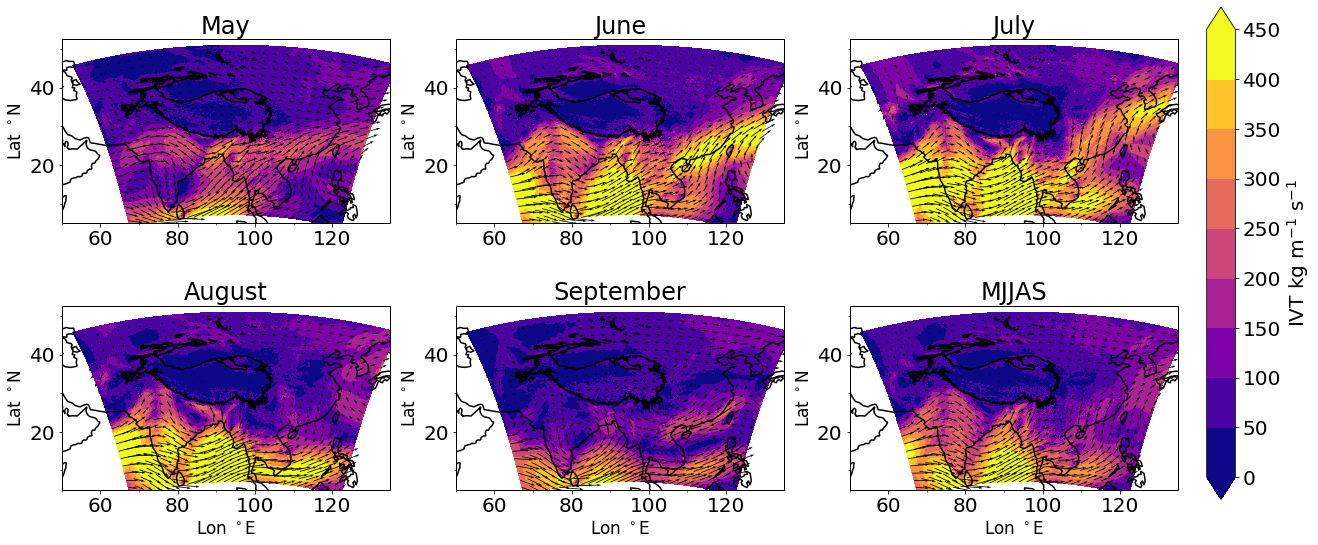

In [212]:
fig =plt.figure(figsize=(20,9))
xlabels=[50,60,70,80,90,100,110,120]
ylabels= [10,20,30,40,50]
skip  =(slice(None,None,10),slice(None,None,10))
fs= 17
c= 'k'

# customizing of colorbar 
cmap=plt.cm.plasma
r = np.arange(0,500,50)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)


skip  =(slice(None,None,25),slice(None,None,25))
x,y = lons, lats

ax1 = plt.subplot(2, 3, 1, projection=ccrs.PlateCarree())
ax1.set_extent([55,135,5,45])
ax1.set_title('May')
ax1.coastlines(linewidth = 1.5)
ax1.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# Plot wind vectors 
ax1.pcolormesh(lons, lats, q_may,norm = norm, cmap = cmap  )    
ax1.quiver(x[skip],y[skip],awt_u_may[skip], awt_v_may[skip], color =c, transform= ccrs.PlateCarree()) 
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=fs)
    

ax2 = plt.subplot(2, 3, 2, projection=ccrs.PlateCarree())
ax2.set_extent([55,135,5,45])
ax2.set_title('June')
ax2.coastlines(linewidth = 1.5)
ax2.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# Plot wind vectors 
ax2.pcolormesh(lons, lats, q_jun,norm = norm, cmap = cmap  )
ax2.quiver(x[skip],y[skip],awt_u_jun[skip], awt_v_jun[skip], color =c, transform= ccrs.PlateCarree())
# axis labels 
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)
ax2.set_ylabel('Lat $^\circ$N',  fontsize=fs)
     

ax3 = plt.subplot(2, 3, 3, projection=ccrs.PlateCarree())
ax3.set_extent([55,135,5,45])
ax3.set_title('July')
ax3.coastlines(linewidth = 1.5)
ax3.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# Plot wind vectors 
ax3.pcolormesh(lons, lats, q_jul,norm = norm, cmap = cmap  )
ax3.quiver(x[skip],y[skip],awt_u_jul[skip], awt_v_jul[skip], color =c, transform= ccrs.PlateCarree())
# axis labels 
ax3.set_xticks(xlabels, xlabels)
ax3.set_yticks(ylabels,ylabels)
ax3.set_ylabel('Lat $^\circ$N',  fontsize=fs)
   

ax4 = plt.subplot(2, 3, 4, projection=ccrs.PlateCarree())
ax4.set_extent([55,135,5,45])
ax4.set_title('August')
ax4.coastlines(linewidth = 1.5)
ax4.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# Plot wind vectors 
ax4.pcolormesh(lons, lats, q_aug,norm = norm, cmap = cmap  )
ax4.quiver(x[skip],y[skip],awt_u_aug[skip], awt_v_aug[skip], color =c, transform= ccrs.PlateCarree())
# axis labels 
ax4.set_xticks(xlabels, xlabels)
ax4.set_yticks(ylabels,ylabels)
ax4.set_xlabel('Lon $^\circ$E',  fontsize=fs)
ax4.set_ylabel('Lat $^\circ$N',  fontsize=fs)
   
    
ax5 = plt.subplot(2, 3, 5, projection=ccrs.PlateCarree())
ax5.set_extent([55,135,5,45])
ax5.set_title('September')
ax5.coastlines(linewidth = 1.5)
ax5.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# Plot wind vectors 
ax5.pcolormesh(lons, lats, q_sep,norm = norm, cmap = cmap)
ax5.quiver(x[skip],y[skip],awt_u_sep[skip], awt_v_sep[skip], color =c, transform= ccrs.PlateCarree())
# axis labels 
ax5.set_xticks(xlabels, xlabels)
ax5.set_yticks(ylabels,ylabels)
ax5.set_xlabel('Lon $^\circ$E',  fontsize=fs)
ax5.set_ylabel('Lat $^\circ$N',  fontsize=fs)


ax6 = plt.subplot(2, 3, 6, projection=ccrs.PlateCarree())
ax6.set_extent([55,135,5,45])
ax6.set_title('MJJAS')
ax6.coastlines(linewidth = 1.5)
ax6.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# Plot wind vectors 
m = ax6.pcolormesh(lons, lats, q_clim,norm = norm, cmap = cmap)
ax6.quiver(x[skip],y[skip],awt_u[skip], awt_v[skip], color =c, transform= ccrs.PlateCarree())
# axis labels 
ax6.set_xticks(xlabels, xlabels)
ax6.set_yticks(ylabels,ylabels)
ax6.set_xlabel('Lon $^\circ$E',  fontsize=fs)
ax6.set_ylabel('Lat $^\circ$N',  fontsize=fs)
      
    
cb_ax1 = fig.add_axes([0.92, 0.14,0.02, 0.76])
cbar = fig.colorbar(m, cax=cb_ax1, extend = 'both', label = 'IVT kg m$^{-1}$ s$^{-1}$')
plt.rcParams.update({'font.size': 20})


plt.savefig('plots/AWT_climatology_WRF9km.png')
plt.show()

## Calculate mean flow vs. eddies 

In [1194]:
import glob
# surface pressures 
sp_files= glob.glob('tmpdir/monthly/*srfc_pressure*')
sp_files.sort()

# monthly primes
uprim_files = glob.glob('tmpdir/processed/qu*prim*nc')
vprim_files = glob.glob('tmpdir/processed/qv*prim*nc')
uprim_files.sort()
vprim_files.sort()

# monthly mean qV
monmean_files = glob.glob('tmpdir/monthly/test/*temperature-geopotential-specific_cloud_ice_water*nc') 
monmean_files.sort()

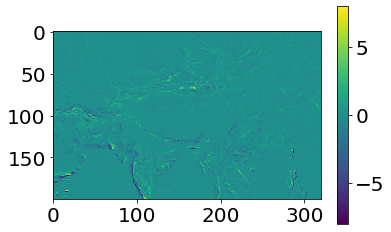

In [1186]:
# import surface term 
srfc= xr.open_dataset('tmpdir/processed/srfc_term200605.nc')['__xarray_dataarray_variable__'][0]
plt.imshow(srfc.values * 86400, vmin =-8, vmax=  8)
plt.colorbar()

In [2704]:
## with 6 hourly primes 

# surface pressures 
sp_files= glob.glob('tmpdir/6hourly_test/*sp19*')

# monthly primes
uprim_files = glob.glob('tmpdir/6hourly_test/qu_prime*')
vprim_files = glob.glob('tmpdir/6hourly_test/qv_prime*')

# monthly mean qV
monmean_files = glob.glob('tmpdir/6hourly_test/climatology.nc') 


In [1144]:
# preprocessing: get spacings 
lats= xr.open_dataset(monmean_files[0])['latitude'].values
lons= xr.open_dataset(monmean_files[0])['longitude'].values
dlat, dlon= atm.get_spacing(lats, lons)

# get pressure levels 
pressure =  xr.open_dataset(monmean_files[0])['level'].values

In [1195]:
# initialize 
conv_mean = np.zeros((200,320))
conv_eddy = np.zeros((200,320))
conv_total = np.zeros((200,320)) 

for ymon in np.arange(20):
    print(ymon)
    # read in all mean fields 
    spdata= xr.open_dataset(sp_files[ymon])
    fields =xr.open_dataset(monmean_files[ymon])
    u = fields.u[0].values
    v = fields.v[0].values
    t = fields.t[0].values
    z = fields.z[0].values
    # specific humidity (water vapour in kg/kg)
    q = fields.q[0].values + fields.clwc[0].values + fields.clwc[0].values
    # surface pressure values 
    sp = spdata.sp[0].values /100
    fields.close()
    spdata.close()
############################## mean flow ############################

    # set geopotential to 0, where surface pressure < 1000 hpa 
    coords = np.where(sp < 1000)

    for i, ilat in enumerate(coords[0]):
        ilon = coords[1][i]
        sp_value = sp[ilat,ilon]
        idx, pl = atm.find_nearest_idx(pressure, sp_value)
        if sp_value > pl:
            idx = idx + 1     
        # set q value below ground to 0 
        q[idx:36, ilat, ilon] = 0

    # convert specific humidity to absolute humidity in kg/m3
    for plev in np.arange(37):
        p_d = (pressure[plev] * 100)/(R*t[plev])
        q[plev] *=  p_d

    # get qV fields 
    qu = q*u
    qv = q*v 

    # colummn integration of q and wind fields 
    quint = atm.column_integration(np.flip(qu, axis = 0), np.flip(z, axis = 0))
    qvint = atm.column_integration(np.flip(qv, axis = 0), np.flip(z, axis = 0))

    # divergence 
    udiv = derivative_u(quint)[:,320:320*2]  
    vdiv = derivative_v(qvint)[200:400, :] 

    # sum derivatives along x and y axis to get divergence 
    conv_mean= (udiv + vdiv)

    ################ transient eddy convergence ############################

    # read in file for one month 
    data= xr.open_dataset(uprim_files[ymon])
    qu_prime = data['__xarray_dataarray_variable__']/84
    data.close()
    data2= xr.open_dataset(vprim_files[ymon])
    qv_prime= data2['__xarray_dataarray_variable__'] /84
    data2.close()
    
    # save monthly mean deviation from mean 
    quvec = (qu + qu_prime)
    qvvec = (qv + qv_prime)

    # set geopotential to 0, where surface pressure < 1000 hpa 
    coords = np.where(sp < 1000)

    for i, ilat in enumerate(coords[0]):
        ilon = coords[1][i]
        sp_value = sp[ilat,ilon]
        idx, pl = atm.find_nearest_idx(pressure, sp_value)
        if sp_value > pl:
            idx = idx + 1
            
        qu_prime[idx:36, ilat, ilon] = 0
        qv_prime[idx:36, ilat, ilon] = 0
        quvec[idx:36, ilat, ilon] = 0
        qvvec[idx:36, ilat, ilon] = 0        
        
    # column integration    
    qu_integrated = atm.column_integration(np.flip(quvec, axis= 0), np.flip(z, axis = 0), ax = 0)    
    qv_integrated = atm.column_integration(np.flip(qvvec, axis= 0), np.flip(z, axis = 0), ax = 0)    

    # divergence calculation 
    udiv = derivative_u(qu_integrated)[:,320:320*2]   
    vdiv = derivative_v(qv_integrated)[200:400, :] 

    # sum derivatives along x and y axis to get divergence 
    conv_total = (udiv + vdiv)

    # colummn integration of q and wind fields 
    quint = atm.column_integration(np.flip(qu_prime, axis = 0), np.flip(z, axis = 0))
    qvint = atm.column_integration(np.flip(qv_prime, axis = 0), np.flip(z, axis = 0))

    # divergence 
    udiv = derivative_u(quint)[:,320:320*2]  
    vdiv = derivative_v(qvint)[200:400, :]  

    # sum derivatives along x and y axis to get divergence 
    conv_eddy = (udiv + vdiv)
     

0


ValueError: operands could not be broadcast together with shapes (960,) (1,318) 

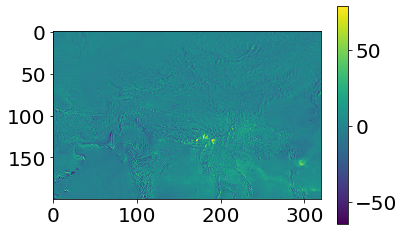

In [1190]:
plt.imshow(-conv_total*86400)
plt.colorbar()

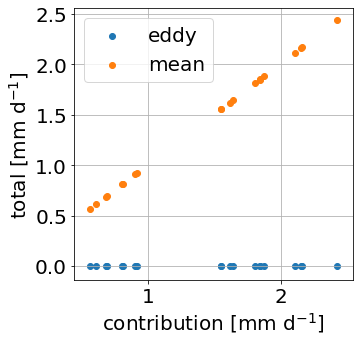

In [452]:
plt.figure(figsize= (5,5))

plt.scatter(total, eddy, label = 'eddy')
plt.scatter(total, mean, label = 'mean')
plt.ylabel('total [mm d$^{-1}$]')
plt.xlabel('contribution [mm d$^{-1}$]')

plt.grid()
plt.legend()

plt.savefig('plots/eddy_vs_meanflow_hourly.png')
plt.show()

In [444]:
# apply land sea mask 
lm= xr.open_dataset('lsm_era5_tp.nc')['lsm'][0]
lsm= np.flip(lm, axis = 0)



# global DEM 
dem = '/media/juli/Data/projects/data/elevation/GMTED2010_15n030_0125deg.nc'
elevations = xarray.open_dataset(dem)['elevation']
elevations_tp= elevations[800:1200, 1840:2480]
lat = np.linspace(800,1199,200)
lon= np.linspace(1840,2479,321)
elevs= elevations_tp.interp(nlat= lat, nlon= lon )[:,:-1]

In [445]:
conv_eddy[:, elevs<3000] = np.nan
conv_mean[:,elevs<3000] = np.nan
conv_total[:, elevs<3000] = np.nan

In [446]:
tpeddy= np.array(())
tpmean = np.array(())
tptotal = np.array(())

for i in np.arange(20):
    tpeddy= np.append(tpeddy,weighted_mean(-conv_eddy[i] * 86400))
    tpmean= np.append(tpmean,weighted_mean(-conv_mean[i] * 86400))
    tptotal= np.append(tptotal,weighted_mean(-conv_total[i]* 86400))
    

In [410]:
# calculate weightes mean area
def weighted_mean(arr):
    dataset=xr.DataArray(arr,  dims= {'latitude':fields.latitude[:-1].values, 'longitude':fields.longitude[:-1].values})
    weights = np.cos(np.deg2rad(fields.latitude[:-1]))
    weights.name = "weights"
    data_weighted = dataset.weighted(weights)
    weighted_mean = data_weighted.mean(("latitude", "longitude"), skipna= True)
    return weighted_mean.values

## Plot 

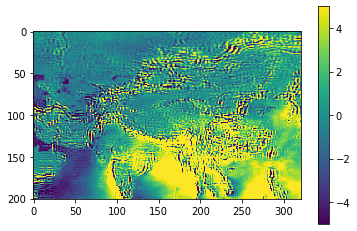

In [4]:
# for comparison 1: mean plot of vimd 
vimd = xr.open_dataset('tmpdir/monthly/vimd_1979_1982.nc')['p84.162'][0]
plt.imshow(-vimd*86400, vmin = -5, vmax = 5)
plt.colorbar()

## Divergence calculation - Spectral 

1. FFT F(f)
2. derivative of FFT (2*np.pi*i*f  * F(f))
3. add to calculate divergence
4. inverse FFT to convert back ( use.real!!)



- n= number of grid cells along dim and L= length of dim in km 
- how to calculate frequency : first quand: w= 2*pi/L ...2*pi2/L...2*pi*n/2L
- how to get i : j after number
- what other step needs to be done when converting back from Fourier space into normal?

In [31]:
# for comparison 2: mean plot of divergence of verticaly integrated water flux
data = xr.open_dataset('tmpdir/monthly/viwvt_1979_1982.nc')
quint= xr.open_dataset('tmpdir/monthly/viwvt_1979_1982.nc')['p71.162'][0]
qvint = xr.open_dataset('tmpdir/monthly/viwvt_1979_1982.nc')['p72.162'][0]
lon= xr.open_dataset('tmpdir/monthly/viwvt_1979_1982.nc')['longitude']
lat = xr.open_dataset('tmpdir/monthly/viwvt_1979_1982.nc')['latitude']


quinti = xr.open_dataset('tmpdir/monthly/reanalysis-era5-single-levels-monthly-means_198108_vertical_integral_of_northward_water_vapour_flux-vertical_integral_of_eastward_water_vapour_flux10-60-50-130.nc')['p71.162'][0]
qvinti = xr.open_dataset('tmpdir/monthly/reanalysis-era5-single-levels-monthly-means_198108_vertical_integral_of_northward_water_vapour_flux-vertical_integral_of_eastward_water_vapour_flux10-60-50-130.nc')['p72.162'][0]

In [6]:
# calculate frequencies for first
def calculate_freq(N):
    l = 2.0 * np.pi * np.arange(N // 2)
    c = np.zeros((1,))
    r = -2.0 * np.pi * np.arange(N // 2 - 1)[::-1]
    return np.concatenate((l,c, r))

In [7]:
# first derivative 
def derivative(f_quint, f_qvint):
    m, n = f_quint.shape
    m2 = m // 2
    n2 = n // 2
    
    df_quint_dx = f_quint.copy()
    df_qvint_dy = f_qvint.copy()
    
    # frequencies 
    f_lat = 2.0 * np.pi * np.fft.fftfreq(m)
    f_lat[m2] = 0.0
    #f_lat *= np.exp(-np.abs(f_lat) / 5)
    f_lat = np.broadcast_to(f_lat.reshape(-1, 1), (m, n))
    
    f_lon = 2.0 * np.pi * np.fft.fftfreq(n)
    f_lon[n2] = 0.0
    #f_lon *= np.exp(-np.abs(f_lon) / 5)
    f_lon = np.broadcast_to(f_lon.reshape(1, -1), (m, n))

    df_qvint_dy *= -1j * f_lat
    df_quint_dx *= 1j * f_lon
    
    #band filtering
    d_n = 50
    d_m = 60
    df_qvint_dy[m2 - d_m : m2 + d_m + 1, :] *= 0.0
    df_quint_dx[:, n2 - d_n : n2 + d_n + 1] *= 0.0
    
    return df_quint_dx,df_qvint_dy

In [89]:
def derivative_u(quint):
    quint_padded = np.hstack([np.fliplr(quint[:-1, :-1]), quint[:-1, :-1], np.fliplr(quint[:-1, :-1])]) 
    f_quint = np.fft.fft(quint_padded, axis=1)

    m, n = f_quint.shape
    m2 = m // 2
    n2 = n // 2
    f_lon= f_quint.copy()
    
    f_lon = 2.0 * np.pi * np.fft.fftfreq(n, d= dlon[:-1,[0]]/2)
    f_lon[:,n2] = 0.0
    
    #f_lon = np.broadcast_to(f_lon.reshape(1, -1), (m, n)) 
    df_quint_dx = f_quint.copy() * 1j * f_lon 
    
    d_n = 50
    df_quint_dx[:, n2 - d_n : n2 + d_n + 1] *= 0.0
    real = np.fft.ifft(df_quint_dx, axis = 1).real
    
    return real[ :, quint[:-1, :-1].shape[1]: quint[:-1, :-1].shape[1] * 2]


In [90]:
def derivative_v(qvint):
    qvint_padded = np.vstack([np.flipud(qvint[:-1, :-1]), qvint[:-1, :-1], np.flipud(qvint[:-1, :-1])]) 
    f_qvint = np.fft.fft(qvint_padded, axis=0)

    m, n = f_qvint.shape
    m2 = m // 2
    n2 = n // 2

    f_lat = 2.0 * np.pi * np.fft.fftfreq(m, d= dlat[0,0]/2) 
    f_lat[m2] = 0.0
    f_lat = np.broadcast_to(f_lat.reshape(-1, 1), (m, n))  
    
    df_qvint_dy = f_qvint.copy() * -1j * f_lat
    
    d_m = 60
    df_qvint_dy[m2 - d_m : m2 + d_m + 1, :] *= 0.0
    real = np.fft.ifft(df_qvint_dy, axis = 0).real
    
    return real[qvint[:-1, :-1].shape[0]: qvint[:-1, :-1].shape[0] * 2, :]


In [93]:
dlat, dlon = atm.get_spacing(lat,lon)
udiff= derivative_u(quint) 
vdiff= derivative_v(qvint)

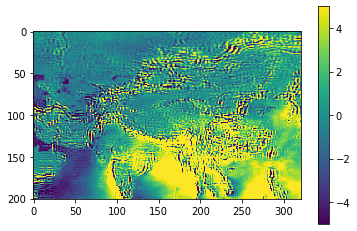

In [28]:

vimd = xr.open_dataset('tmpdir/monthly/vimd_1979_1982.nc')['p84.162'][0]
#smoothed = wrf.smooth2d(-vimd*86400 , passes = 4)
plt.imshow(-vimd*86400, vmin = -5, vmax = 5)
plt.colorbar()

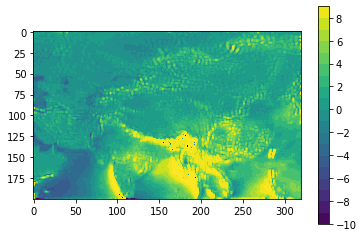

In [94]:
import wrf
smoothed2 = wrf.smooth2d(-(vdiff + udiff)*86400 , passes = 2)
plt.imshow(-(vdiff + udiff)*86400 , vmin = -5, vmax = 5)
plt.contourf(smoothed2, levels = np.arange(-10,10))
plt.colorbar()

In [1727]:
# Fourier transformation
m, n = quint.shape
f_quint = np.fft.fft(quint, axis=1 )
f_qvint = np.fft.fft(qvint, axis=0 )


f_quint_deriv,f_qvint_deriv = derivative(f_quint, f_qvint)

# inverse fft 
quint_back = np.fft.ifft(f_quint_deriv, axis = 1).real
qvint_back = np.fft.ifft(f_qvint_deriv, axis = 0).real


In [1929]:
# scale with lengths of axes 

L1 = np.nansum(dlat, axis = 0)[0] # constant domain length along latitudes 
L2 = np.nansum(dlon, axis = 1 ) # main length along longitudes is latitude-dependent
l2 = np.tile(L2, [320,1]).T[1::,:]


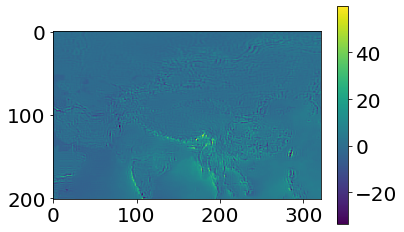

In [1278]:
# for comparison 1: mean plot of vimd 
vimd = xr.open_dataset('tmpdir/monthly/vimd_1979_1982.nc')['p84.162'][0]
plt.imshow(-vimd*86400)
plt.colorbar()

<Figure size 720x720 with 0 Axes>

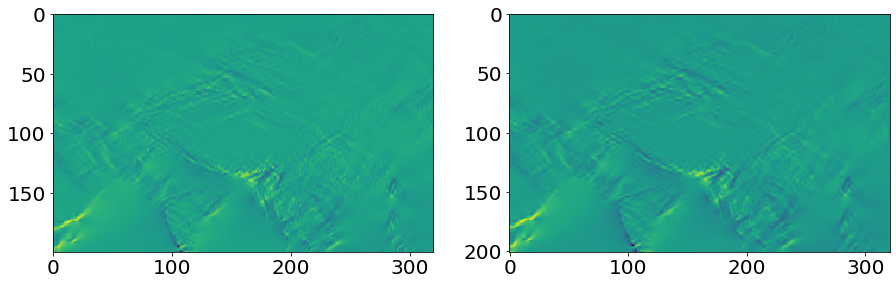

In [2457]:
plt.figure(figsize=(10,10))

f,axes = plt.subplots(1,2, figsize= (15,15))
m= axes[0].imshow(udiff)
#plt.colorbar(m)

b= axes[1].imshow(udiv)
#plt.colorbar(b)


<Figure size 720x720 with 0 Axes>

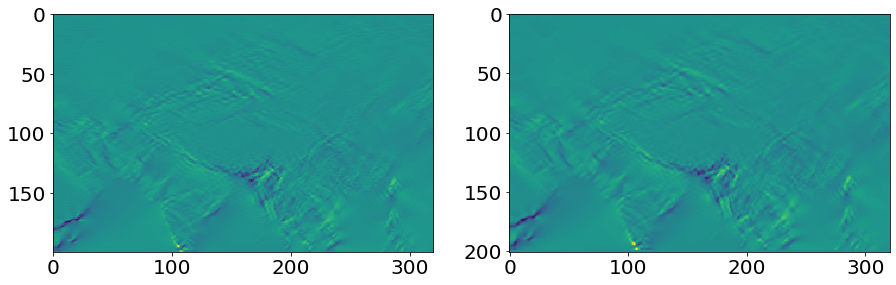

In [2456]:
plt.figure(figsize=(10,10))

f,axes = plt.subplots(1,2, figsize= (15,15))
m= axes[0].imshow(vdiff)
#plt.colorbar(m)
b= axes[1].imshow(vdiv)
#plt.colorbar(b)


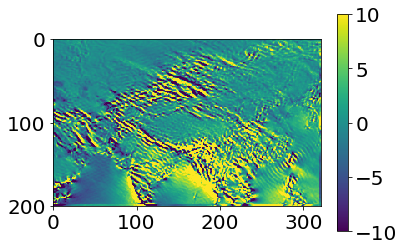

In [2455]:
udev = atm.dy_dlon(quint, dlon) 
vdev = atm.dy_dlat(qvint, dlat) 
udiv = np.hstack([udev, np.zeros((201,2))])
vdiv = np.vstack([vdev, np.zeros((2,321))])
div = (udiv+vdiv)
plt.imshow(- div* 86400, vmin = -10, vmax= 10 )
plt.colorbar()

In [1170]:
import wrf
smoothed_mean = wrf.smooth2d(-(conv_mean) *86400 , passes = 2)
smoothed_eddy = wrf.smooth2d(-(conv_eddy)*84600  , passes = 2)
smoothed_total = wrf.smooth2d(-(vdiff + udiff)*84600 , passes = 2)


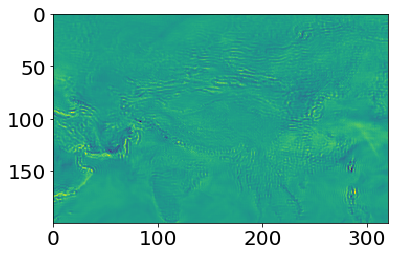

In [1167]:
plt.imshow(conv_eddy)

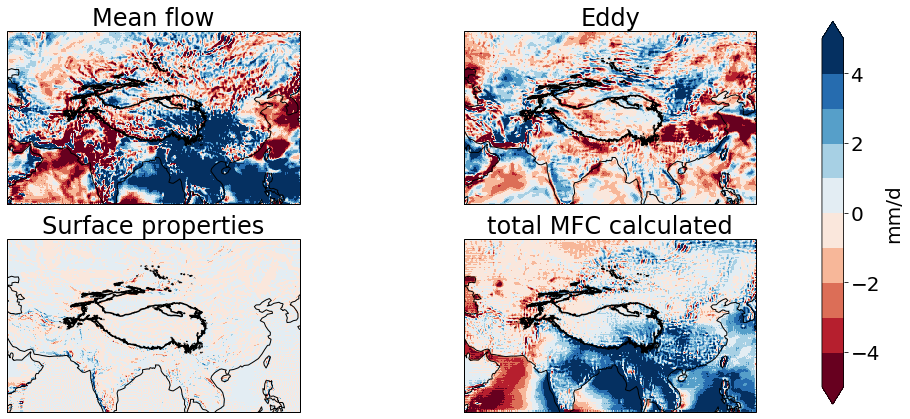

In [1199]:
fig =plt.figure(figsize=(15,7))
xlabels=[50,60,70,80,90,100,110,120]
ylabels= [10,20,30,40,50]

fs= 25

# customizing of colorbar 
cmap=plt.cm.RdBu
r = np.arange(-5,6)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)


ax1 = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([50,130,10,50])
ax1.set_title('Mean flow')
m1= ax1.pcolormesh(lons, lats, smoothed_mean, cmap = cmap , norm = norm )
ax1.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines()   

ax2 = plt.subplot(2, 2, 2, projection=ccrs.PlateCarree())
ax2.set_title('Eddy')
ax2.set_extent([50,130,10,50])
m= ax2.pcolormesh(lons, lats, smoothed_eddy, cmap = cmap , norm = norm )
ax2.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
ax2.coastlines()  

ax3 = plt.subplot(2, 2, 4, projection=ccrs.PlateCarree())
ax3.set_title('total MFC calculated')
ax3.set_extent([50,130,10,50])
m= ax3.pcolormesh(lons, lats, smoothed_total, cmap = cmap , norm = norm )
ax3.contour(elevations.lon.values,elevations.lat.values,elevations.data.T, [3000], cmap = 'Greys_r')
ax3.coastlines()  
    
ax4 = plt.subplot(2, 2, 3, projection=ccrs.PlateCarree())
ax4.set_title('Surface properties')
ax4.set_extent([50,130,10,50])
m= ax4.pcolormesh(lons, lats, -srfc*86400, cmap = cmap ,norm = norm )
ax4.contour(elevations.lon.values,elevations.lat.values,elevations.data.T, [3000], cmap = 'Greys_r')
ax4.coastlines()   
    
cb_ax1 = fig.add_axes([0.92, 0.14,0.02, 0.76])
cbar = fig.colorbar(m1, cax=cb_ax1, extend = 'both', label = 'mm/d')
plt.rcParams.update({'font.size': 20})
plt.savefig('plots/ERA5_decompose_mean_eddy_srfc.png')
plt.show()

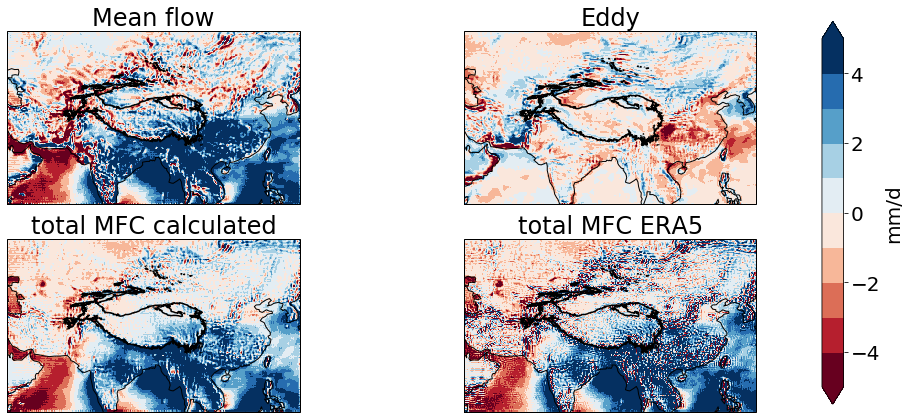

In [2545]:
fig =plt.figure(figsize=(15,7))
xlabels=[50,60,70,80,90,100,110,120]
ylabels= [10,20,30,40,50]

fs= 25

# customizing of colorbar 
cmap=plt.cm.RdBu
r = np.arange(-5,6)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)


ax1 = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([50,130,10,50])
ax1.set_title('Mean flow')
m1= ax1.pcolormesh(lons, lats, smoothed_mean, cmap = cmap , norm = norm )
ax1.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines()   

ax2 = plt.subplot(2, 2, 2, projection=ccrs.PlateCarree())
ax2.set_title('Eddy')
ax2.set_extent([50,130,10,50])
m= ax2.pcolormesh(lons, lats, smoothed_eddy, cmap = cmap , norm = norm )
ax2.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
ax2.coastlines()  

ax3 = plt.subplot(2, 2, 3, projection=ccrs.PlateCarree())
ax3.set_title('total MFC calculated')
ax3.set_extent([50,130,10,50])
m= ax3.pcolormesh(lons, lats, smoothed_total, cmap = cmap , norm = norm )
ax3.contour(elevations.lon.values,elevations.lat.values,elevations.data.T, [3000], cmap = 'Greys_r')
ax3.coastlines()  
    
ax4 = plt.subplot(2, 2, 4, projection=ccrs.PlateCarree())
ax4.set_title('total MFC ERA5')
ax4.set_extent([50,130,10,50])
m= ax4.pcolormesh(lons, lats, -vimd * 86400 , cmap = cmap ,norm = norm )
ax4.contour(elevations.lon.values,elevations.lat.values,elevations.data.T, [3000], cmap = 'Greys_r')
ax4.coastlines()   
    
cb_ax1 = fig.add_axes([0.92, 0.14,0.02, 0.76])
cbar = fig.colorbar(m1, cax=cb_ax1, extend = 'both', label = 'mm/d')
plt.rcParams.update({'font.size': 20})

plt.savefig('plots/ERA5_decompose_mean_eddy_fft.png')
plt.show()

## Thermodynamic vs. dynamic components 

In [368]:
# initialize 
thermo = np.zeros((200,320))
dynam = np.zeros((200,320))
qvdiv = np.zeros((37, 200, 320))
wvdiv = np.zeros((37, 200, 320))
qudiv = np.zeros((37, 200 ,320))
wudiv = np.zeros((37, 200 ,320))


for ymon in np.arange(20):
    print(ymon)
    # read in all mean fields 
    spdata= xr.open_dataset(sp_files[ymon])
    fields =xr.open_dataset(monmean_files[ymon])
    u = fields.u[0].values
    v = fields.v[0].values
    t = fields.t[0].values
    z = fields.z[0, :,:-1, :-1].values
    # specific humidity (water vapour in kg/kg)
    q = fields.q[0].values + fields.clwc[0].values + fields.clwc[0].values
    # surface pressure values 
    sp = spdata.sp[0].values[:-1,:-1] /100
    fields.close()
    spdata.close()
############################## mean flow ############################    
    # convert specific humidity to absolute humidity in kg/m3
    for plev in np.arange(37):
        p_d = (pressure[plev] * 100)/(R*t[plev])
        q[plev] *=  p_d

        # divergence for each level wind vectors 
        qudiv[plev] = derivative_u(q[plev])[:,320:320*2]  
        qvdiv[plev]  = derivative_v(q[plev])[200:400, :] 

        # divergence for each level q
        wudiv[plev]  = derivative_u(u[plev])[:,320:320*2]  
        wvdiv[plev] = derivative_v(v[plev])[200:400, :]    

    # set geopotential to 0, where surface pressure < 1000 hpa 
    coords = np.where(sp < 1000)

    for i, ilat in enumerate(coords[0]):
        ilon = coords[1][i]
        sp_value = sp[ilat,ilon]
        idx, pl = atm.find_nearest_idx(pressure, sp_value)
        if sp_value > pl:
            idx = idx + 1     
        # set q value below ground to 0 
        q[idx:36, ilat, ilon] = 0
        u[idx:36, ilat, ilon] = 0
        v[idx:36, ilat, ilon] = 0
        
    # product 
    dyn = q[:,:-1,:-1] * (wudiv + wvdiv) 
    qu_th = u[:,:-1,:-1] * qudiv
    qv_th = v[:,:-1,:-1] * qvdiv 
    th = (qu_th + qv_th) 
    
    # colummn integration of thermodynamic 
    dynam += atm.column_integration(np.flip(dyn, axis = 0), np.flip(z, axis = 0))
    thermo += atm.column_integration(np.flip(th, axis = 0), np.flip(z, axis = 0))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


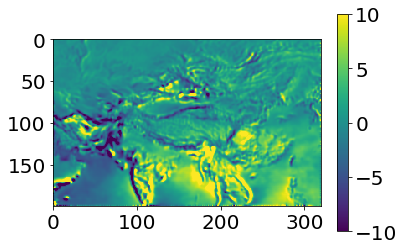

In [383]:
smoothed = wrf.smooth2d( - (thermo/20 + dynam/20) , passes = 4)
plt.imshow(smoothed * 86400, vmin = -10, vmax = 10)
plt.colorbar()

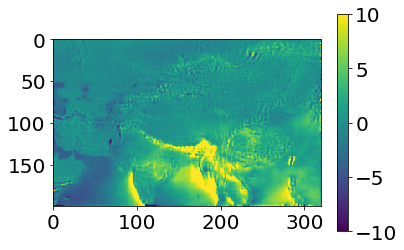

In [382]:
smoothed2 = wrf.smooth2d(-(vdiff + udiff)*86400 , passes = 3)
plt.imshow(smoothed2 , vmin = -10, vmax = 10) 
plt.colorbar()

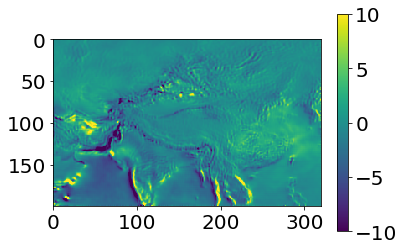

In [371]:
smoothed_thermo = wrf.smooth2d( - (thermo/20) * 86400 , passes = 2)
plt.imshow(smoothed_thermo, vmin = -10, vmax = 10)
plt.colorbar()

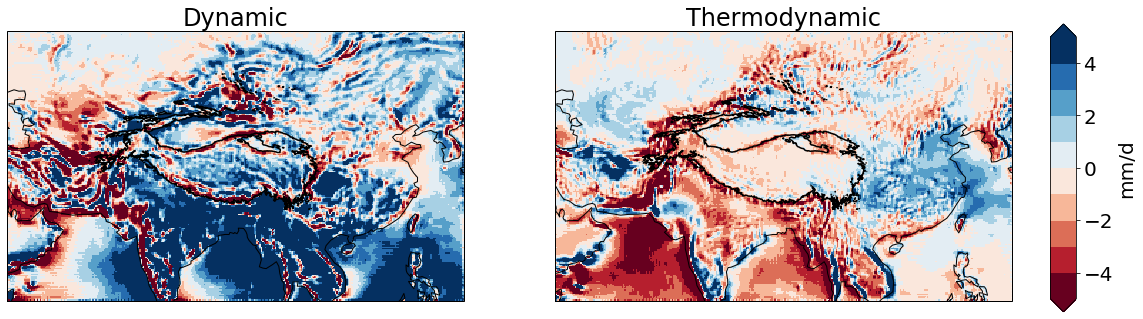

In [390]:
fig =plt.figure(figsize=(18,8))
xlabels=[50,60,70,80,90,100,110,120]
ylabels= [10,20,30,40,50]

fs= 25

# customizing of colorbar 
cmap=plt.cm.RdBu
cmap2=plt.cm.BrBG
r = np.arange(-5, 6)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
r = np.arange(-0.5,0.5,0.01)
norm2 = colors.BoundaryNorm(boundaries= r,  ncolors= 256)


ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_title('Dynamic')
ax1.set_extent([50,130,10,50])
m= ax1.pcolormesh(lons, lats, smoothed_dynam , cmap = cmap , norm = norm )
ax1.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines()  

ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([50,130,10,50])
ax2.set_title('Thermodynamic')
m2= ax2.pcolormesh(lons, lats, smoothed_thermo, cmap = cmap , norm = norm )
ax2.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
ax2.coastlines()   


#cb_ax1 = fig.add_axes([0.93, 0.25,0.02, 0.5])
cb_ax2 = fig.add_axes([0.93, 0.25,0.02, 0.5])

#cbar = fig.colorbar(m1, cax=cb_ax1, extend = 'both')
cbar = fig.colorbar(m2, cax=cb_ax2, extend = 'both', label = 'mm/d')
plt.rcParams.update({'font.size': 20})

plt.savefig('plots/ERA5_decompose_thermodyn_dynam_fft.png')
plt.show()

## Check trend in temperature and specific humidity 

In [1200]:
data = 'cache/srfc-monthly/surface_pressure_clim.nc'
sp = xr.open_dataset(data).sp.values

In [1201]:
file = 'cache/pressure-monthly/timeseries_1979-2019.nc'
fldmean = 'cache/pressure-monthly/fldmean_1979-2019.nc'
temp = 'cache/pressure-monthly/timetemp_1979-2019.nc'
d = xr.open_dataset(file)
temp = xr.open_dataset(temp)
q = d.q[:,:, :, :].values
t = temp.t[:,:, :, :].values
z = d.z[:,:, :, :].values
q_prof = xr.open_dataset(fldmean).q[:,:,0,0]
pressure= d.level.values

In [278]:
# set geopotential to 0, where surface pressure < 1000 hpa 
qint = np.zeros((41,201,321))

coords = np.where(sp < 1000)
for i, ilat in enumerate(coords[0]):
    ilon = coords[1][i]
    sp_value = sp[ilat,ilon]
    idx, pl = atm.find_nearest_idx(pressure, sp_value)
    if sp_value > pl:
        idx = idx + 1     
    # set q value below ground to 0 
    q[:, idx:36, ilat, ilon] = 0
    
# convert specific humidity to absolute humidity in kg/m3
for plev in np.arange(37):
    p_d = (pressure[plev] * 100)/(R*t[:,plev,:,:])
    q[:,plev,:,:] *=  p_d 
    
for i in np.arange(41):
    qint[i] = atm.column_integration(np.flip(q[i], axis = 0), np.flip(z[i], axis = 0), ax = 0)    


In [279]:
q = d.q[:,:, :, :]
xarr = xr.DataArray(qint, dims= {'time':q.time.values, 'latitude':q.latitude.values, 'longitude':q.longitude.values})
xarr.to_netcdf('cache/pressure-monthly/qint.nc')

In [3429]:
from scipy.stats import linregress
trends = np.zeros(quint.shape)
significance = np.zeros(quint.shape)

for la in np.arange(201):
    for lo in np.arange(321):
        slope, intercept, r_value, p_value, std_err = linregress(x=time, y =qint[:,la,lo] )
        trends[la,lo] =  slope 
        significance[la,lo]  = p_value

In [3325]:
import matplotlib as mpl
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

    
norm = MidpointNormalize(vmin=-0.3, vmax=1.3, midpoint=0)
cmap = 'coolwarm_r' 
    

In [251]:
trendfile = 'cache/pressure-monthly/trendy.nc'
trend = xr.open_dataset(trendfile)['__xarray_dataarray_variable__'][0]

In [22]:
# get significant trend coordinates 
q = d.q[:,:, :, :]
y,x = np.meshgrid( q.longitude.values, q.latitude.values)
las = x[significance < 0.05]
los= y[significance <0.05]

NameError: name 'significance' is not defined

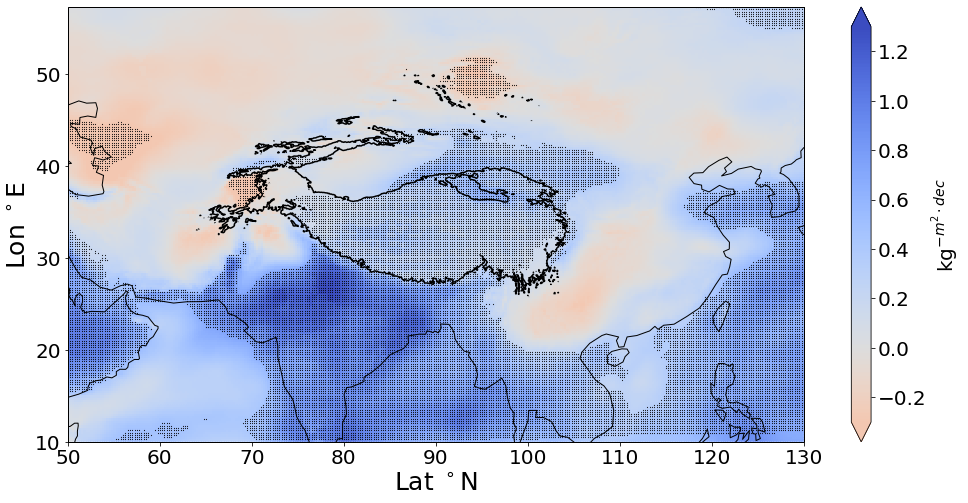

In [3518]:
# calculate trend for each grid cell 
plt.figure(figsize= (17,8))

lons = q.longitude.values
lats = q.latitude.values

ax1 = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])

m=plt.pcolormesh(lons, lats,trend*10,  cmap = cmap, norm = norm)

plt.scatter(los,las, color= 'k', s= 0.05, marker = 'd')


plt.colorbar(m , label = 'kg$^{-m^2 \cdot dec}$', extend = 'both')
ax1.contour(elevations.lon,elevations.lat, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines(color = 'black')

ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_xlabel('Lat $^\circ$N', fontsize=fs)
ax1.set_ylabel('Lon $^\circ$E', fontsize=fs)


plt.savefig('plots/ERA5_trend_vertically_integrated_water_vapor.png')
plt.show()

## Surface temperatures 

In [240]:
file = 'cache/srfc-monthly/era5_surfacetemps_timeseries.nc'
d = xr.open_dataset(file)
temp= d.t2m.values
time= np.arange(41)

file = 'cache/srfc-monthly/surfacetemps_trend.nc'
d = xr.open_dataset(file)
temp_trend= d.t2m.values[0]

lats = d.latitude.values
lons = d.longitude.values

In [227]:
from scipy.stats import linregress
trends = np.zeros((201,321))
significance = np.zeros((201,321))

for la in np.arange(201):
    for lo in np.arange(321):
        slope, intercept, r_value, p_value, std_err = linregress(x=time, y =temp[:,la,lo] )
        trends[la,lo] =  slope 
        significance[la,lo]  = p_value

In [245]:
# get significant trend coordinates 
y,x = np.meshgrid( d.longitude.values, d.latitude.values)
las = x[significance < 0.05]
los= y[significance <0.05]

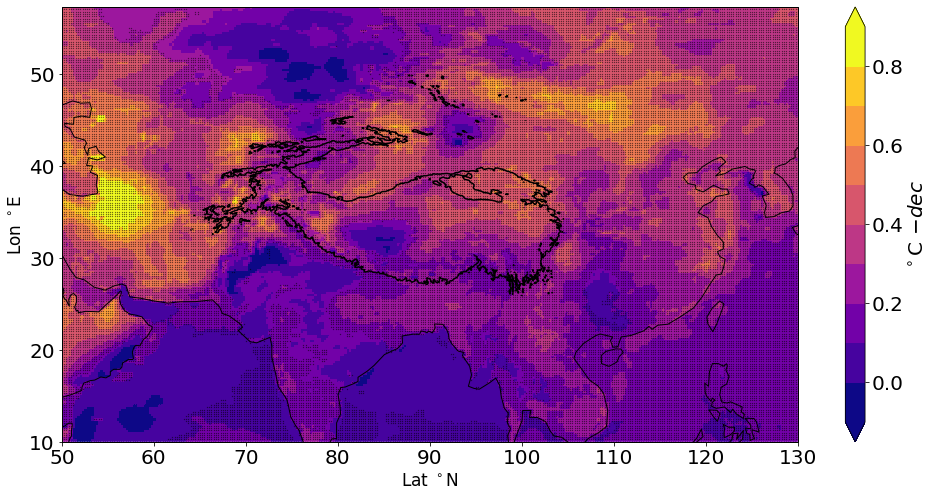

In [310]:
plt.figure(figsize= (17,8))

r = np.arange(-0.1, 1.0,0.1)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)


ax1 = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])

m=plt.pcolormesh(lons, lats,trends*10,  cmap = 'plasma', norm = norm)

plt.scatter(los,las, color= 'k', s= 0.05, marker = 'o')


plt.colorbar(m , label = '$^\circ$C $-{dec}$', extend = 'both')
ax1.contour(elevations.lon,elevations.lat, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines(color = 'black')

ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_xlabel('Lat $^\circ$N', fontsize=fs)
ax1.set_ylabel('Lon $^\circ$E', fontsize=fs)

plt.savefig('plots/ERA5_trend_srfc_temperatures.png')
plt.show()

## Specific humidity increase per deg C 

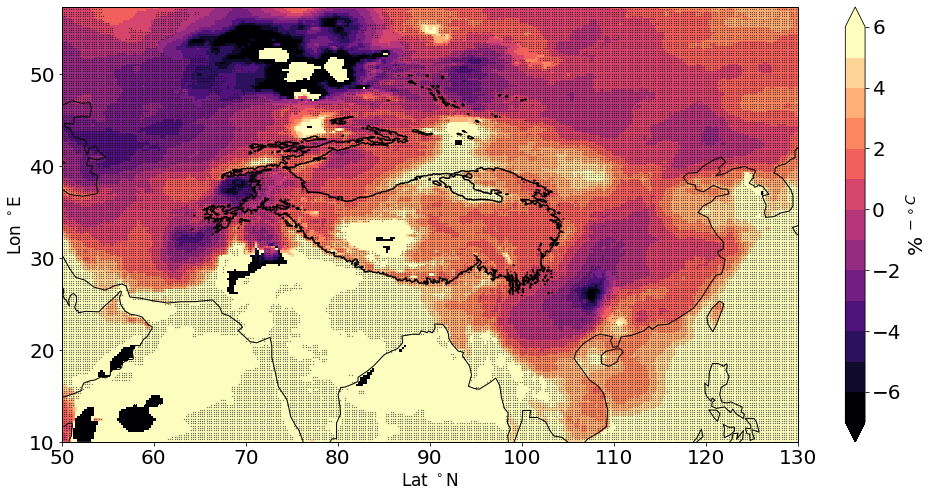

In [328]:
plt.figure(figsize= (17,8))

r = np.arange(-7,7,1)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)


ax1 = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),50])

m=plt.pcolormesh(lons, lats,trend_per_deg,  cmap = 'magma', norm = norm)

plt.scatter(los,las, color= 'k', s= 0.05, marker = 'o')


plt.colorbar(m , label = '% $^{-\circ C}$', extend = 'both')
ax1.contour(elevations.lon,elevations.lat, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines(color = 'black'
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_xlabel('Lat $^\circ$N', fontsize=fs)
ax1.set_ylabel('Lon $^\circ$E', fontsize=fs)

plt.savefig('plots/ERA5_trend_cc.png')
plt.show()

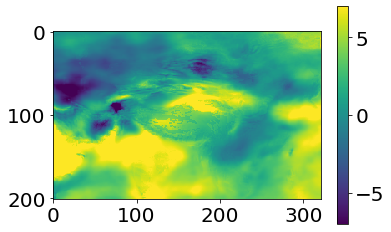

In [306]:
plt.imshow(trend_as_percent, vmin = -7, vmax = 7)
plt.colorbar()

In [327]:
trend_as_percent = (trend * 41 / np.nanmean(qint, axis = 0)) * 100
trend_per_deg = trend_as_percent  / (trends*41)

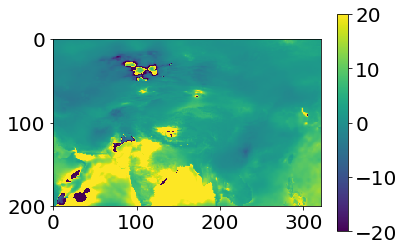

In [298]:
plt.imshow(trend_per_deg, vmin = -20, vmax = 20)
plt.colorbar()